## Importing Dependencies

In [2]:
!unzip IWSLTdataset.zip -d ./data/

Archive:  IWSLTdataset.zip
   creating: ./data/Transformers_data/
  inflating: ./data/__MACOSX/._Transformers_data  
  inflating: ./data/Transformers_data/dev.en  
  inflating: ./data/__MACOSX/Transformers_data/._dev.en  
  inflating: ./data/Transformers_data/dev.fr  
  inflating: ./data/__MACOSX/Transformers_data/._dev.fr  
  inflating: ./data/Transformers_data/train.fr  
  inflating: ./data/__MACOSX/Transformers_data/._train.fr  
  inflating: ./data/Transformers_data/train.en  
  inflating: ./data/__MACOSX/Transformers_data/._train.en  
  inflating: ./data/Transformers_data/test.fr  
  inflating: ./data/__MACOSX/Transformers_data/._test.fr  
  inflating: ./data/Transformers_data/test.en  
  inflating: ./data/__MACOSX/Transformers_data/._test.en  


In [79]:
import os
import sys
import tarfile
import zipfile as zf
import requests as rq

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import re
import time
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu
# from google.colab import drive
# drive.mount('content/drive/')

In [7]:
# os.chdir('drive/My Drive')
# ROOT = os.getcwd()
# os.chdir(ROOT + '/Colab Notebooks')

In [4]:
try:
    %tensorflow_version 2.x
except:
    pass
import tensorflow as tf

from tensorflow.keras import layers
import tensorflow_datasets as tfds

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [5]:
# checking for tensorflow version and verify we are using GPU
print(f'TensorFlow Version: {tf.__version__}')
print(f'Using CUDA: {tf.test.is_built_with_cuda()}')
print(f'Using GPU: {tf.config.list_physical_devices("GPU")}')
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Number of GPUs available: ", len(physical_devices))

tf.config.experimental.set_memory_growth(physical_devices[0], True)

TensorFlow Version: 2.15.0
Using CUDA: True
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs available:  1


In [6]:
data_dir = './data/Transformers_data/'
# french and english dev, train, and test data
with open(data_dir + "dev.en", mode='r', encoding='utf=8') as f:
  EN_dev = f.read()
with open(data_dir + "train.en", mode='r', encoding='utf=8') as f:
  EN_train = f.read()
with open(data_dir + "test.en", mode='r', encoding='utf=8') as f:
  EN_test = f.read()
with open(data_dir + "dev.fr", mode='r', encoding='utf=8') as f:
  FR_dev = f.read()
with open(data_dir + "train.fr", mode='r', encoding='utf=8') as f:
  FR_train = f.read()
with open(data_dir + "test.fr", mode='r', encoding='utf=8') as f:
  FR_test = f.read()

In [7]:
EN_dev

'You know, one of the intense pleasures of travel and one of the delights of ethnographic research is the opportunity to live amongst those who have not forgotten the old ways, who still feel their past in the wind, touch it in stones polished by rain, taste it in the bitter leaves of plants.\nJust to know that Jaguar shamans still journey beyond the Milky Way, or the myths of the Inuit elders still resonate with meaning, or that in the Himalaya, the Buddhists still pursue the breath of the Dharma, is to really remember the central revelation of anthropology, and that is the idea that the world in which we live does not exist in some absolute sense, but is just one model of reality, the consequence of one particular set of adaptive choices that our lineage made, albeit successfully, many generations ago.\nAnd of course, we all share the same adaptive imperatives.\nWe\'re all born. We all bring our children into the world.\nWe go through initiation rites.\nWe have to deal with the inexo

In [8]:
EN_train

'David Gallo: This is Bill Lange. I\'m Dave Gallo.\nAnd we\'re going to tell you some stories from the sea here in video.\nWe\'ve got some of the most incredible video of Titanic that\'s ever been seen, and we\'re not going to show you any of it.\nThe truth of the matter is that the Titanic -- even though it\'s breaking all sorts of box office records -- it\'s not the most exciting story from the sea.\nAnd the problem, I think, is that we take the ocean for granted.\nWhen you think about it, the oceans are 75 percent of the planet.\nMost of the planet is ocean water.\nThe average depth is about two miles.\nPart of the problem, I think, is we stand at the beach, or we see images like this of the ocean, and you look out at this great big blue expanse, and it\'s shimmering and it\'s moving and there\'s waves and there\'s surf and there\'s tides, but you have no idea for what lies in there.\nAnd in the oceans, there are the longest mountain ranges on the planet.\nMost of the animals are in

In [9]:
# corpus cleaning
def preprocess(corpus):
  corpus = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".$$$", corpus)
  corpus = re.sub(r".\$\$\$", '', corpus)
  corpus = re.sub(r"  +", " ", corpus)
  corpus = re.sub(r"<.*?>","", corpus)
  corpus = re.sub(r"<url>.*?</url>","", corpus)
  corpus = re.sub(r'http\S+','', corpus)
  corpus = corpus.split('\n')
  return corpus

In [10]:
len(EN_train.split('\n'))

30001

In [11]:
len(FR_train.split('\n'))

30001

In [12]:
en_train = preprocess(EN_train)
en_dev = preprocess(EN_dev)
en_test = preprocess(EN_test)
fr_train = preprocess(FR_train)
fr_dev = preprocess(FR_dev)
fr_test = preprocess(FR_test)

In [13]:
print(f"{len(en_train)}\n{len(fr_train)}")

30001
30001


Building Vocab from train sets alone <br>
alt approach : combine valid and train sets for larger vocab size

In [14]:
def buildingvocab(train_corpus):
  corpus_iter = tqdm(train_corpus, desc="Building Vocabulary")
  tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      corpus_iter,
      target_vocab_size=2**13
      )
  corpus_iter.close()
  return tokenizer

In [15]:
tokenizer_en = buildingvocab(en_train)
tokenizer_fr = buildingvocab(fr_train)

Building Vocabulary: 100%|██████████| 30001/30001 [00:00<00:00, 33367.54it/s]


In [16]:
# vocab size of tokenizer
vocab_size_en = tokenizer_en.vocab_size
vocab_size_fr = tokenizer_fr.vocab_size
print(f"Vocab Size for tokenizer_en : {vocab_size_en} \nVocab Size for tokenizer_fr : {vocab_size_fr}")

Vocab Size for tokenizer_en : 8330 
Vocab Size for tokenizer_fr : 8186


In [17]:
# adding sos and eos tokens to indicate the beginning of a sequence and end of a sequence
vocab_size_en, vocab_size_fr = vocab_size_en + 2, vocab_size_fr + 2


In [18]:
x_train = [[vocab_size_en-2] + tokenizer_en.encode(sentence) + [vocab_size_en-1]
          for sentence in en_train]
y_train = [[vocab_size_fr-2] + tokenizer_fr.encode(sentence) + [vocab_size_fr-1]
          for sentence in fr_train]
x_val = [[vocab_size_en-2] + tokenizer_en.encode(sentence) + [vocab_size_en-1]
         for sentence in en_dev]
y_val = [[vocab_size_en-2] + tokenizer_fr.encode(sentence) + [vocab_size_en-1]
          for sentence in fr_dev]

In [19]:
print(len(x_train), len(y_train))

30001 30001


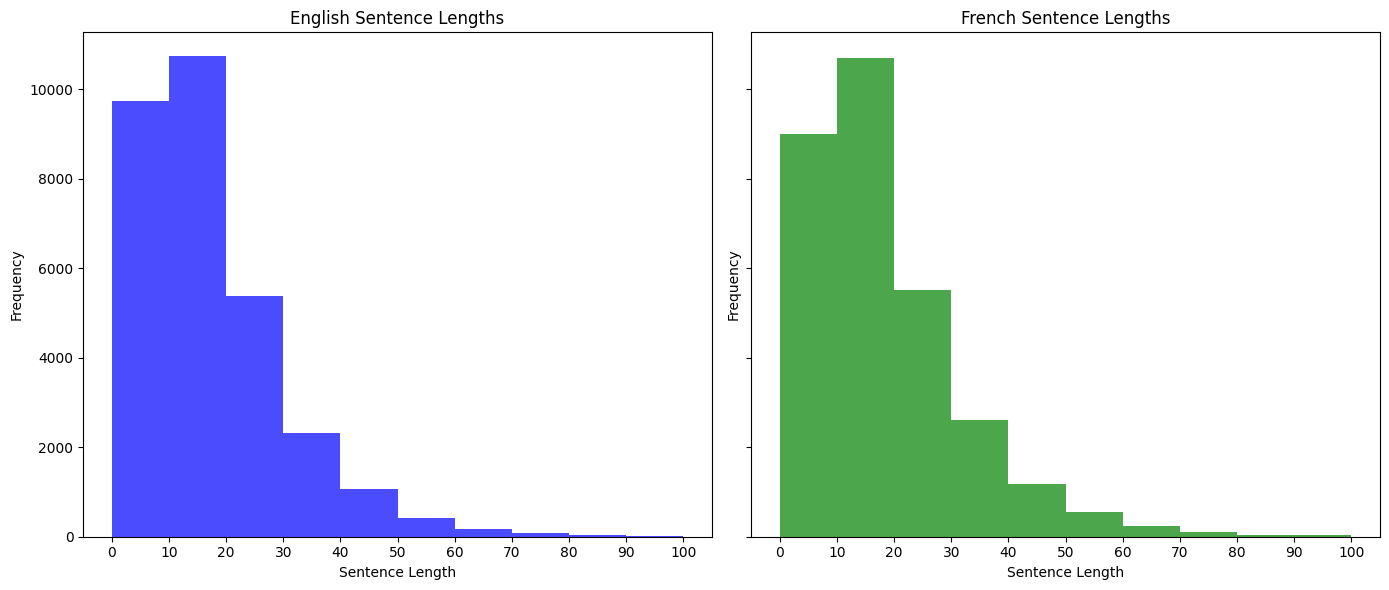

In [20]:
# deciding the max_lenght on inputs and outputs
en_lengths = [len(sentence.split()) for sentence in en_train]
fr_lengths = [len(sentence.split()) for sentence in fr_train]

# Define bins for the histograms
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Plot histograms in separate subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

axes[0].hist(en_lengths, bins=bins, color='blue', alpha=0.7)
axes[0].set_title('English Sentence Lengths')
axes[0].set_xlabel('Sentence Length')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(bins)

axes[1].hist(fr_lengths, bins=bins, color='green', alpha=0.7)
axes[1].set_title('French Sentence Lengths')
axes[1].set_xlabel('Sentence Length')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(bins)
plt.tight_layout()
plt.show()

In [21]:
# maximum length calculated using 95 percintile
max_length_en = int(np.percentile(en_lengths, 95))
max_length_fr = int(np.percentile(fr_lengths, 95))
max_length = int((max_length_en + max_length_fr) / 2)
print(f"Max Length (English): {max_length_en}")
print(f"Max Length (French): {max_length_fr}")
print(f"Average Maximum Length: {max_length}")

Max Length (English): 42
Max Length (French): 44
Average Maximum Length: 43


In [22]:
# removing long sentences (> 43) from both inputs and outputs to decrease computational time
idx_to_rem = [count for count, sent in enumerate(x_train) if len(sent) > max_length]
for idx in reversed(idx_to_rem):
  del x_train[idx]
  del y_train[idx]
# print(len(x_train))
idx_to_rem = [count for count, sent in enumerate(y_train) if len(sent) > max_length]
for idx in reversed(idx_to_rem):
  del x_train[idx]
  # try:
  #   del x_train[idx]
  # except IndexError:
  #   print("Input {idx}")
  del y_train[idx]


In [23]:
print(len(x_train), len(y_train))

24545 24545


In [24]:
# padding the sentences
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=max_length)
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=max_length)

In [25]:
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=max_length)
y_val = tf.keras.preprocessing.sequence.pad_sequences(y_val,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=max_length)

In [26]:
total_dataset_size = len(x_train) + len(x_val) + len(en_test)
total_dataset_size

26737

In [27]:
BATCH_SIZE = 64 # since low compute power
BUFFER_SIZE = 24000 # buffer size >= total_dataset_size

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) # tensors of x and y are created in the tf datasets

train_dataset = train_dataset.cache() # improves the perf of the pipeline by creating cache elems of the dataset in the memory
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE) # improves training speed

In [28]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(BATCH_SIZE)  # No need to shuffle validation data
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [29]:
# positional encoding
class PositionalEncoding(layers.Layer):
  def __init__(self):
    super(PositionalEncoding, self).__init__()
  def get_angles(self, pos, i, d_model):
    '''
      pos = (seq_len, 1) matrix
      i = (1, d_model) matrix
      d_model = siz of embedding vectors
    '''
    angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
    return pos * angles

  def call(self, inputs):
    '''
      inputs = word embeddings - (batch_size, seq_length, d_model)
    '''
    seq_length = inputs.shape.as_list()[-2]
    d_model = inputs.shape.as_list()[-1]

    angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                             np.arange(d_model)[np.newaxis :],
                             d_model)
    angles[:, 0::2] = np.sin(angles[:, 0::2])
    angles[:, 1::2] = np.cos(angles[:, 1::2])

    pos_encoding = angles[np.newaxis, ...]
    return inputs + tf.cast(pos_encoding, tf.float32)

In [30]:
if os.path.isdir('../img') is False:
  os.mkdir('../img')

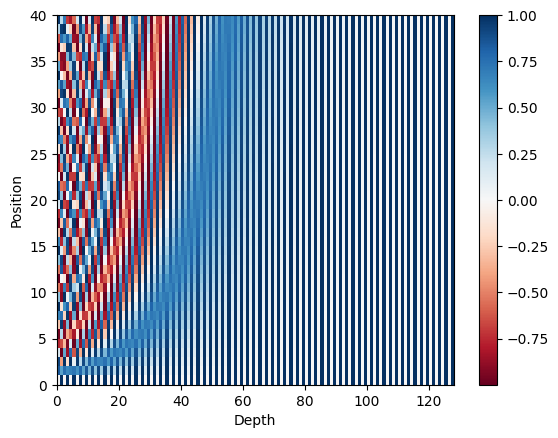

In [31]:
pos_encoding = PositionalEncoding().call(tf.zeros([1, 40, 128], tf.float32))

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.savefig('../img/pos_enc.png')
plt.show()

In [77]:
# calculating attention
def scaled_dot_product_attention(queries, keys, values, mask):
  '''
    three vectors q, k, v and mask
    returns the attention and attention weights
  '''
  product = tf.matmul(queries, keys, transpose_b=True) # dot product of q and k

  keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32) # dimension of keys
  scaled_product = product / tf.math.sqrt(keys_dim) # product of q and v divided by sqrt(keys_dimension)

  if mask is not None: # if look-ahead mask is required
    scaled_product += (mask * 1e-9)

  attention_weights = tf.nn.softmax(scaled_product, axis=-1)
  attention = tf.matmul(attention_weights, values) # dot product of attentiuon matrix and values gives the attention

  return attention, attention_weights



In [76]:
class MultiHeadAttention(layers.Layer):

    # nb_proj is the number of heads
    def __init__(self, nb_proj):
        super(MultiHeadAttention, self).__init__()
        self.nb_proj = nb_proj

    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.nb_proj == 0

        # Calculate the head dimensions.
        self.d_proj = self.d_model // self.nb_proj

        # These layers contain the weights for the linear transformations
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)

        # Used to transform after concatenating the weighted value vectors
        self.final_lin = layers.Dense(units=self.d_model)

    # This method splits the query, key, and value vectors by the number of heads
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        shape = (batch_size,
                 -1,
                 self.nb_proj,
                 self.d_proj)

        # Reshape the tensor to account for the multiple heads and reduced vector dimension
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)

        # Reconfigure the axeses.
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)

    def call(self, queries, keys, values, mask):
        '''
        If this is the first attention layer of the encoder, then all vector inputs are the same vector.
        For later layers, this is the output of the previous layer.
        For the decoder, keys and values are the output of the encoder.
            The queries is the inferred words up to this time step.
        '''
        batch_size = tf.shape(queries)[0]

        # Initialize the weight matrices
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)

        # Split the vectors by number of heads
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)

        # Get attention and weights
        attention, attention_weights = scaled_dot_product_attention(queries,
                                                                    keys,
                                                                    values,
                                                                    mask)
        # Flip dims 1 and 2
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])

        # Concat all the attention vectors
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))

        # Transform the concated vectors to reshape back to (batch_size, seq_length, d_model)
        outputs = self.final_lin(concat_attention)

        return outputs, attention_weights

In [62]:
class EncoderLayer(layers.Layer):

    def __init__(self, FFN_units, nb_proj, dropout_rate):
      '''
      FFN-units    - # of nodes for the point wise feed forward layer
      nb_proj      - # of heads
      dropout_rate - The dropout rate for the layers
      '''
      super(EncoderLayer, self).__init__()
      self.FFN_units = FFN_units
      self.nb_proj = nb_proj
      self.dropout_rate = dropout_rate

    # This is a tensorflow layers method. Automatically called by __call__
    # to automatically build the layers.
    def build(self, input_shape):

        self.d_model = input_shape[-1]

        # Multi-head attention
        self.multi_head_attention = MultiHeadAttention(self.nb_proj)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)

        # Point wise feed forward
        self.dense_1 = layers.Dense(units=self.FFN_units, activation="relu")
        self.dense_2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, mask, training):
        '''
        inputs   -> Input tensor of shape (batch_size, seq_length, d_model)
        mask     -> Padding mask to ignore padding zeros as data
        training -> Boolean - If 1, then use dropout, else not
        '''
        # Attention sub-layer
        # Retain only the attention. Don't need to return weights in this layer.
        attention, _ = self.multi_head_attention(inputs,
                                                 inputs,
                                                 inputs,
                                                 mask)
        attention = self.dropout_1(attention, training=training)
        attention = self.norm_1(attention + inputs)

        # Point-Wise Feed Forward sub-layer
        outputs = self.dense_1(attention)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        outputs = self.norm_2(outputs + attention)

        # Returns tensor of shape (batch_size, seq_length, d_model)
        return outputs

In [63]:
class Encoder(layers.Layer):
    '''
    nb_layers    -> Number of encoder layers
    FFN_units    -> Number of nodes in the FFN
    nb_proj      -> Number of attention heads
    dropout_rate -> Droput rate
    vocab_size   -> The size of the vocabulary
    d_model      -> Size of embedding vectors
    name         -> Name of the layer
    '''
    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)

        # Number of encoder layers
        self.nb_layers = nb_layers
        # Embedding dimension
        self.d_model = d_model

        # Initialize embedding, positional encoding, droppout, and encoding layers
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.enc_layers = [EncoderLayer(FFN_units,
                                        nb_proj,
                                        dropout_rate)
                           for _ in range(nb_layers)]

    def call(self, inputs, mask, training):
        '''
        inputs   -> Tokenized input of shape (batch_size, seq_length)
        mask     -> Attention mask
        training -> Boolean
        '''
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)

        # Forward pass
        for i in range(self.nb_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        # Returns tensor of shape (batch_size, seq_length, d_model)
        return outputs


In [64]:
class DecoderLayer(layers.Layer):
    '''
    FFN-units    -> # of nodes for the point wise feed forward layer
    nb_proj      -> # of heads
    dropout_rate -> The dropout rate for the layers
    '''
    def __init__(self, FFN_units, nb_proj, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.nb_proj = nb_proj
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.d_model = input_shape[-1]

        # Masked Multi-head attention layer
        self.multi_head_attention_1 = MultiHeadAttention(self.nb_proj)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)

        # encoder-decoder Multi-head attention
        self.multi_head_attention_2 = MultiHeadAttention(self.nb_proj)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)

        # Feed foward
        self.dense_1 = layers.Dense(units=self.FFN_units,
                                    activation="relu")
        self.dense_2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        '''
        input       -> Decoder output
        enc_outputs -> Encoder output
        mask_1      -> Look-ahead mask
        mask_2      -> Padding mask
        training    -> Boolean for dropout
        '''
        # Masked Multi-head attention layer
        # Return attention, attention weights
        attention, attn_wt_1 = self.multi_head_attention_1(inputs,
                                                           inputs,
                                                           inputs,
                                                           mask_1)
        attention = self.dropout_1(attention, training)
        attention = self.norm_1(attention + inputs)

        # Encoder-Decoder Multi-head attention layer
        # Return attention, attention weights
        attention_2, attn_wt_2 = self.multi_head_attention_2(attention,
                                                             enc_outputs,
                                                             enc_outputs,
                                                             mask_2)
        attention_2 = self.dropout_2(attention_2, training)
        attention_2 = self.norm_2(attention_2 + attention)

        # FNN
        outputs = self.dense_1(attention_2)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_3(outputs, training)
        outputs = self.norm_3(outputs + attention_2)

        # Return attention vector, attention weights for each attention layer
        return outputs, attn_wt_1, attn_wt_2

In [65]:
class Decoder(layers.Layer):
    '''
    nb_layers    -> Number of encoder layers
    FFN_units    -> Number of nodes in the FFN
    nb_proj      -> Number of attention heads
    dropout_rate -> Droput rate
    vocab_size   -> The size of the vocabulary
    d_model      -> Size of embedding vectors
    name         -> Name of the layer
    '''
    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.d_model = d_model
        self.nb_layers = nb_layers

        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)

        # Initialize the decoder layers.
        self.dec_layers = [DecoderLayer(FFN_units,
                                        nb_proj,
                                        dropout_rate)
                           for i in range(nb_layers)]

    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        '''
        input       -> Decoder output
        enc_outputs -> Encoder output
        mask_1      -> Look-ahead mask
        mask_2      -> Padding mask
        training    -> Boolean for dropout
        '''
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)

        # Iterate over the decoder layers.
        for i in range(self.nb_layers):

            attention_weights = {}

            # Block 1 and block2 are the attention weights from each attention head of the layer
            outputs, block1, block2 = self.dec_layers[i](outputs, enc_outputs, mask_1, mask_2, training)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2


        return outputs, attention_weights

In [66]:
class Transformer(tf.keras.Model):
    '''
    vocab_size_enc -> Vocabulary size of the encoder input
    vocab_size_dec -> Vocabulary size of the decoder input
    d_model        -> Embedding size
    nb_layers      -> Number of encoder and decoder layers
    FFN_units      -> Noumber of nodes in the FNNs
    nb_proj        -> Number of heads
    dropout_rate   -> Dropout rate throught model
    name           -> Layer name
    '''
    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)

        self.encoder = Encoder(nb_layers,
                               FFN_units,
                               nb_proj,
                               dropout_rate,
                               vocab_size_enc,
                               d_model)

        self.decoder = Decoder(nb_layers,
                               FFN_units,
                               nb_proj,
                               dropout_rate,
                               vocab_size_dec,
                               d_model)

        self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")

    def create_padding_mask(self, seq):

        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):

        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask

    def call(self, enc_inputs, dec_inputs, training):

        enc_mask = self.create_padding_mask(enc_inputs)
        dec_mask_1 = tf.maximum(
            self.create_padding_mask(dec_inputs),
            self.create_look_ahead_mask(dec_inputs)
        )
        dec_mask_2 = self.create_padding_mask(enc_inputs)

        # encoder output
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)

        # dec_outputs, attention_weights
        dec_outputs, attention_weights = self.decoder(dec_inputs,
                                                      enc_outputs,
                                                      dec_mask_1,
                                                      dec_mask_2,
                                                      training)

        # This is the prediction
        outputs = self.last_linear(dec_outputs)

        # Return prediction (batch_size, tar_seq_len, target_vocab_size), and attention_weight matrix
        return outputs, attention_weights

In [67]:
tf.keras.backend.clear_session()

# Hyper-parameters
D_MODEL = 128 # 512
NB_LAYERS = 2 # 6
FFN_UNITS = 512 # 2048
NB_PROJ = 8 # 8
DROPOUT_RATE = 0.1 # 0.1

# Initialize the transformer
transformer = Transformer(vocab_size_enc=vocab_size_en,
                          vocab_size_dec=vocab_size_fr,
                          d_model=D_MODEL,
                          nb_layers=NB_LAYERS,
                          FFN_units=FFN_UNITS,
                          nb_proj=NB_PROJ,
                          dropout_rate=DROPOUT_RATE)


In [68]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")

def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

In [69]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(tf.cast(step, tf.float32))
        arg2 = tf.cast(step, tf.float32) * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(D_MODEL)

# Use the Atom Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

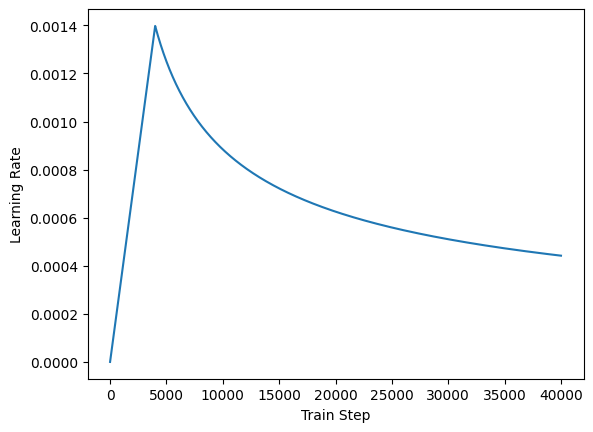

In [70]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.savefig('./data/lr.png')

In [71]:
if os.path.isdir('../ckpt') is False:
    os.mkdir('../ckpt')

In [72]:
checkpoint_path = "../ckpt/"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print("Latest checkpoint restored!")

In [78]:
EPOCHS = 10
for epoch in range(EPOCHS):
    print("Start of epoch {}".format(epoch+1))
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (enc_inputs, targets)) in enumerate(train_dataset):

        # Include the start token which shifts sequence to the right
        dec_inputs = targets[:, :-1]

        # Target without the start token. The end token is included to know when the
        # model reaches the end of the sequence
        dec_outputs_real = targets[:, 1:]

        with tf.GradientTape() as tape:
            predictions, _ = transformer(enc_inputs, dec_inputs, True)
            loss = loss_function(dec_outputs_real, predictions)

        # Calculate and apply the gradients
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

        train_loss(loss)
        train_accuracy(dec_outputs_real, predictions)

        if batch % 50 == 0:
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()))

    ckpt_save_path = ckpt_manager.save()
    print("Saving checkpoint for epoch {} at {}".format(epoch+1,
                                                        ckpt_save_path))
    print("Time taken for 1 epoch: {} secs\n".format(time.time() - start))

Start of epoch 1


Epoch 1 Batch 0 Loss 4.4186 Accuracy 0.0000
Epoch 1 Batch 50 Loss 4.3650 Accuracy 0.0004
Epoch 1 Batch 100 Loss 4.3214 Accuracy 0.0118
Epoch 1 Batch 150 Loss 4.2759 Accuracy 0.0165
Epoch 1 Batch 200 Loss 4.2168 Accuracy 0.0202
Epoch 1 Batch 250 Loss 4.1519 Accuracy 0.0235
Epoch 1 Batch 300 Loss 4.0686 Accuracy 0.0264
Epoch 1 Batch 350 Loss 3.9809 Accuracy 0.0292
Saving checkpoint for epoch 1 at ../ckpt/ckpt-1
Time taken for 1 epoch: 178.43399214744568 secs

Start of epoch 2
Epoch 2 Batch 0 Loss 3.2752 Accuracy 0.0592
Epoch 2 Batch 50 Loss 3.2203 Accuracy 0.0633
Epoch 2 Batch 100 Loss 3.1898 Accuracy 0.0680
Epoch 2 Batch 150 Loss 3.1539 Accuracy 0.0724
Epoch 2 Batch 200 Loss 3.1132 Accuracy 0.0760
Epoch 2 Batch 250 Loss 3.0732 Accuracy 0.0798
Epoch 2 Batch 300 Loss 3.0204 Accuracy 0.0838
Epoch 2 Batch 350 Loss 2.9653 Accuracy 0.0876
Saving checkpoint for epoch 2 at ../ckpt/ckpt-2
Time taken for 1 epoch: 126.3715329170227 secs

Start of epoch 3
Epoch 3 Batch 0 Loss 2.6244 Accuracy 0.1190

In [78]:
# Define a function to calculate BLEU score
def calculate_bleu_score(reference, translation):
    return corpus_bleu(reference, translation)

EPOCHS = 10

# Lists to store accuracy, loss, and BLEU scores
accuracy_history = []
loss_history = []
bleu_history = []

for epoch in range(EPOCHS):
    print("Start of epoch {}".format(epoch+1))
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()
    reference_sentences = []  # List to store reference sentences
    generated_sentences = []  # List to store generated sentences

    for (batch, (enc_inputs, targets)) in enumerate(train_dataset):

        # Include the start token which shifts sequence to the right
        dec_inputs = targets[:, :-1]

        # Target without the start token. The end token is included to know when the
        # model reaches the end of the sequence
        dec_outputs_real = targets[:, 1:]

        with tf.GradientTape() as tape:
            predictions, _ = transformer(enc_inputs, dec_inputs, True)
            loss = loss_function(dec_outputs_real, predictions)

        # Calculate and apply the gradients
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

        train_loss(loss)
        train_accuracy(dec_outputs_real, predictions)

        if batch % 50 == 0:
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()))

    # BLEU Evaluation (assuming you have access to the reference translations)
    for (enc_inputs, targets) in val_dataset:
        dec_inputs = targets[:, :-1]
        dec_outputs_real = targets[:, 1:]
        predictions, _ = transformer(enc_inputs, dec_inputs, False)
        generated_sentences.extend(convert_tokens_to_strings(predictions))
        reference_sentences.extend(convert_tokens_to_strings(dec_outputs_real))

    bleu_score = calculate_bleu_score(reference_sentences, generated_sentences)
    bleu_history.append(bleu_score)
    print("Epoch {} BLEU Score: {:.4f}".format(epoch+1, bleu_score))

    # Logging
    accuracy_history.append(train_accuracy.result().numpy())
    loss_history.append(train_loss.result().numpy())

    # Save checkpoint
    ckpt_save_path = ckpt_manager.save()
    print("Saving checkpoint for epoch {} at {}".format(epoch+1, ckpt_save_path))
    print("Time taken for 1 epoch: {} secs\n".format(time.time() - start))